In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# initialize data attributes and loaders
%env BATCH_SIZE=128
%env DATASET_NAME=QPM_species
%env EMB_DIMS=128
%env MODEL_NAME=flow_mse
%env OOD=0

from config import load_config

config = load_config()
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

env: BATCH_SIZE=128
env: DATASET_NAME=QPM_species
env: EMB_DIMS=128
env: MODEL_NAME=flow_mse
env: OOD=0


In [3]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species
Loaded 263794 images
Dataset type val label type: species
Loaded 33867 images
Dataset type test label type: species
Loaded 34090 images
Dataset type train label type: species
Loaded 111649 images
Dataset type val label type: species
Loaded 14695 images
Dataset type test label type: species
Loaded 14700 images


In [4]:
# model id for each ood_k
model_ids = ['3qdutcy1', 'czgx4bod', '72y7x1fk', 'cqp59iho', 'fwur6c78']
model_id = model_ids[config.ood[0]]
print(model_id)

3qdutcy1


In [5]:
model = config.get_model()

In [6]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [7]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [8]:
from models.common import edl_probs
from tqdm.auto import tqdm

ind_u_norms = []
ood_u_norms = []
rnd_u_norms = []

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")
    
ind_u_norms = np.array(ind_u_norms).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

ind_v_norms = np.array(ind_v_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_u_norms.shape, ind_v_norms.shape)
print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 267/267 [00:24<00:00, 10.74it/s]


test InD - OK


100%|██████████| 1102/1102 [01:38<00:00, 11.15it/s]


test OoD - OK


100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


test RnD - OK
(34090,) (34090,)
(141044,) (141044,)
(12800,) (12800,)


In [9]:
ind_u_norms_scaled = np.tanh(ind_u_norms)
ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_u_norms.mean(), ind_u_norms.std())
print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

4.1157093 0.055238534
4.0981007 0.027644735
4.8702097 0.30709454
0.00592948 0.001563476
0.005391255 0.0014390844
10.3674345 0.41509607


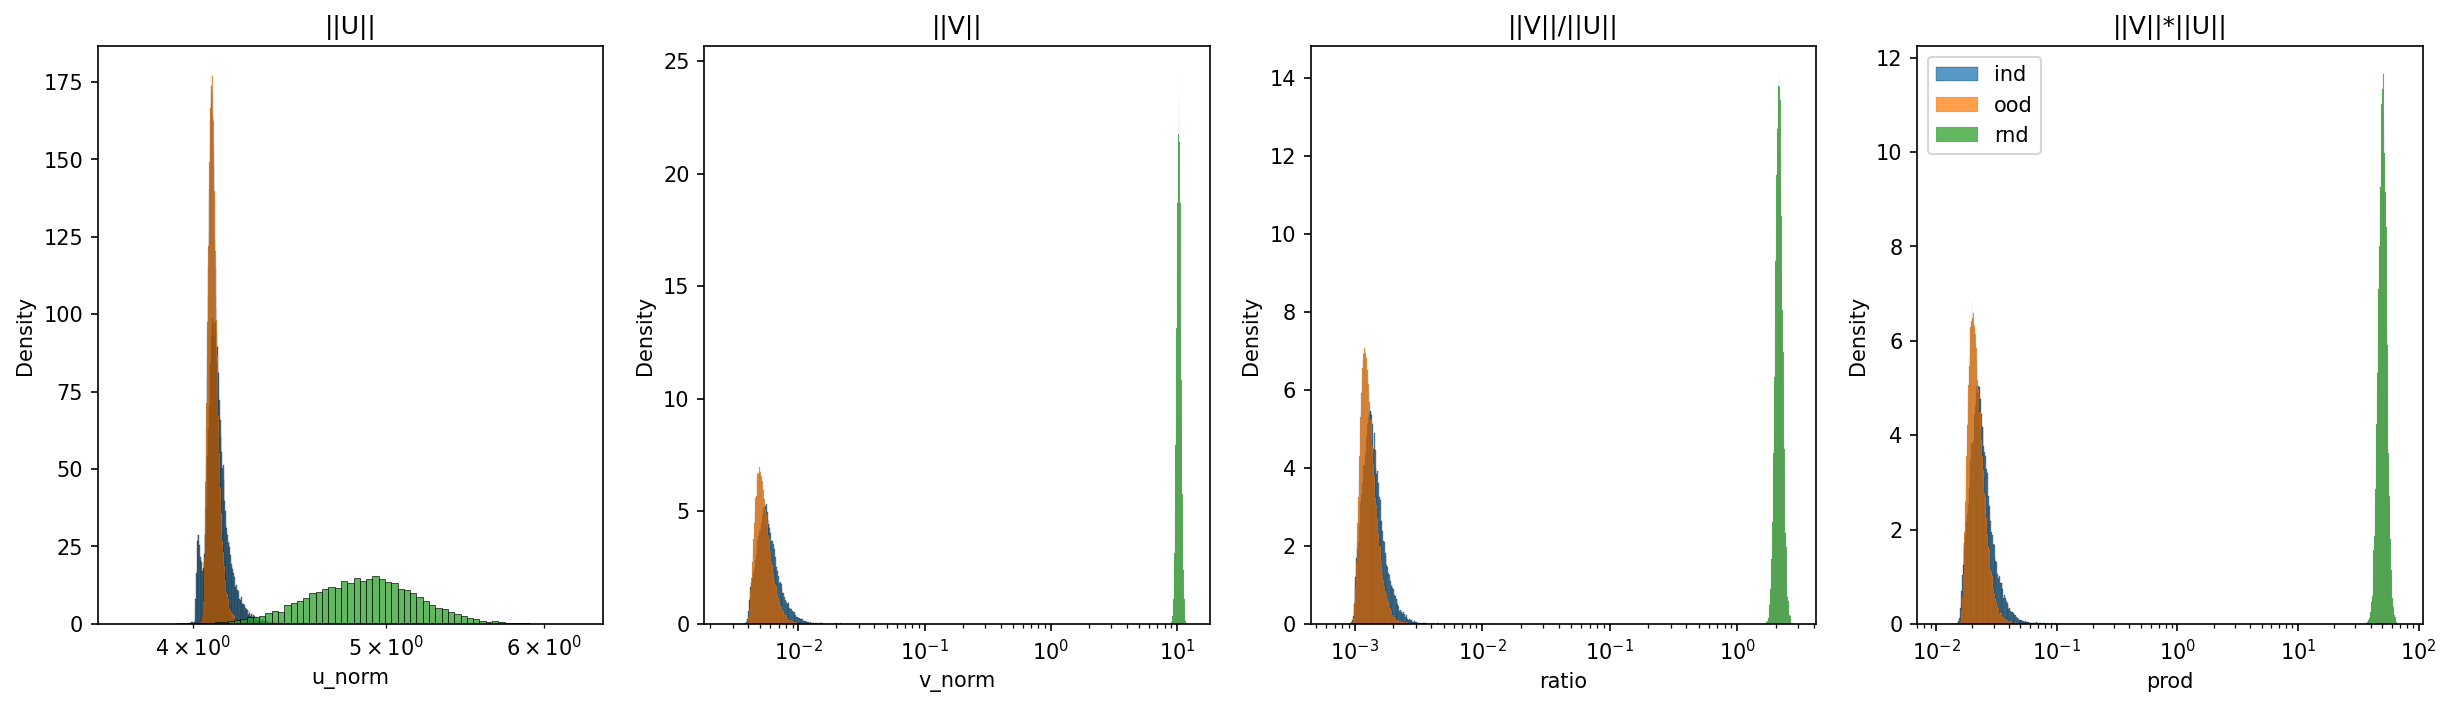

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms))
data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))

sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.savefig(f"assets/figures/qpm_species_flow_mse_M128_ood_u_{config.ood[0]}.png")

In [11]:
from scipy import stats
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
print(ks_ind_ood)

Ind 0.0027211218 0.064717494 0.06199637
Ood 0.0027211218 0.35723323 0.3545121
Rnd 8.698455 11.960841 3.2623863
KstestResult(statistic=0.19580640778177572, pvalue=0.0, statistic_location=0.0054295203, statistic_sign=-1)
